# **Imports and Libraries**

In [14]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve
from scipy import stats

# **Image Preprocessing and Feature Extraction**

In [15]:
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Image not found or cannot be loaded: {image_path}")
    _, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)
    return img, binary

def extract_features(binary_image):
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    features = []
    for contour in contours:
        area = cv2.contourArea(contour)
        x, y, w, h = cv2.boundingRect(contour)
        solidity = area / (w * h)
        features.append((area, solidity))
    return features

def assign_label(solidity):
    if solidity > 0.40:
        return "Confidence"
    elif solidity > 0.178:
        return "Confusion"
    elif solidity > 0.01:
        return "Stress"
    else:
        return None

# **Load and Preprocess Images**

In [16]:
def load_and_preprocess_images(image_folder):
    images = []
    labels = []
    filenames = []
    for root, _, files in os.walk(image_folder):
        for file in sorted(files):
            if file.lower().endswith(('.jpg', '.png')):
                image_path = os.path.join(root, file)
                img, binary = preprocess_image(image_path)
                features = extract_features(binary)
                
                if not features:
                    print(f"Warning: No features found in {file}")
                
                for area, solidity in features:
                    label = assign_label(solidity)
                    if label is None:
                        continue
                    images.append((area, solidity))
                    labels.append(label)
                    filenames.append(file)
    
    return np.array(images), np.array(labels), filenames

# **Label Summary**

In [17]:
def label_summary(labels, filenames, label_encoder):
    original_labels = label_encoder.inverse_transform(labels)

    label_counts = {
        "Confidence": [],
        "Confusion": [],
        "Stress": []
    }

    for label, filename in zip(original_labels, filenames):
        
        label_counts[label].append(filename)

    print("Label Summary:")
    for label, files in label_counts.items():
        print(f"{label}: {len(files)} image(s)")
        if len(files) > 0:
            print(f"  {', '.join(files[:5])}...")

# **Exploratory Data Analysis (EDA)**

               Area      Solidity
count  11083.000000  11083.000000
mean     397.075702      0.353870
std      535.943015      0.257893
min        0.500000      0.010417
25%        3.000000      0.125000
50%       23.500000      0.250000
75%     1082.500000      0.665654
max     1622.500000      0.865313
            Filename    Area  Solidity       Label
0  circle100_104.png  1251.5  0.782188  Confidence
1  circle100_106.png  1261.0  0.768902  Confidence
2  circle100_109.png  1250.0  0.743605  Confidence
3  circle100_118.png  1264.0  0.734030  Confidence
4  circle100_125.png  1292.5  0.750581  Confidence


Label Summary:
Confidence: 3667 image(s)
  circle100_104.png, circle100_106.png, circle100_109.png, circle100_118.png, circle100_125.png...
Confusion: 3559 image(s)
  circle101_223.png, circle102_119.png, circle102_119.png, circle102_119.png, circle102_127.png...
Stress: 3857 image(s)
  circle102_119.png, circle102_119.png, circle102_127.png, circle102_170.png, circle102_170.png...


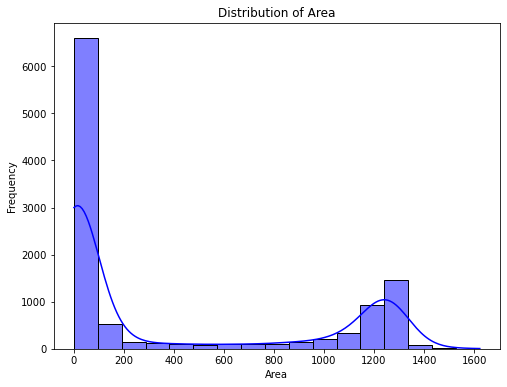

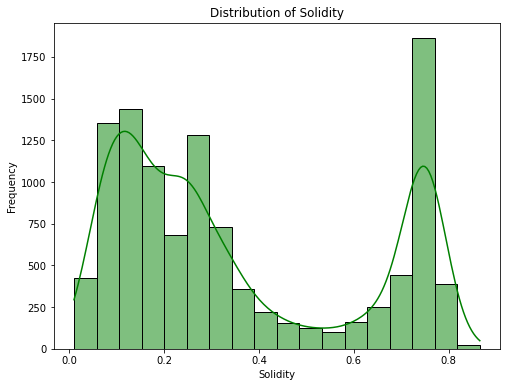

In [18]:
dataset_path = r'C:\Users\Laptop\extracted_bubbles\filled_circles'
images, labels, filenames = load_and_preprocess_images(dataset_path)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)

areas = [feature[0] for feature in images]
solidities = [feature[1] for feature in images]

df = pd.DataFrame({
    'Filename': filenames,
    'Area': areas,
    'Solidity': solidities,
    'Label': labels
})

print(df.describe())
print(df.head())
print("\n")
label_summary(y_encoded, filenames, label_encoder)

plt.figure(figsize=(8, 6))
sns.histplot(df['Area'], kde=True, color='blue')
plt.title('Distribution of Area')
plt.xlabel('Area')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(df['Solidity'], kde=True, color='green')
plt.title('Distribution of Solidity')
plt.xlabel('Solidity')
plt.ylabel('Frequency')
plt.show()

# **Bivariate Analysis**

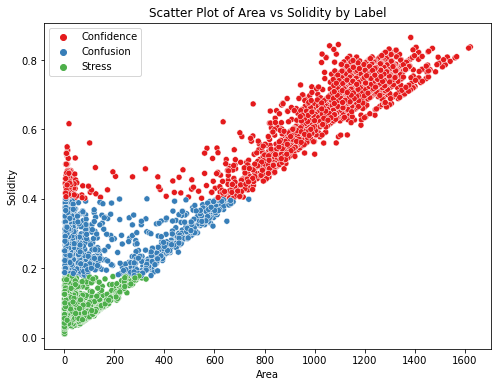

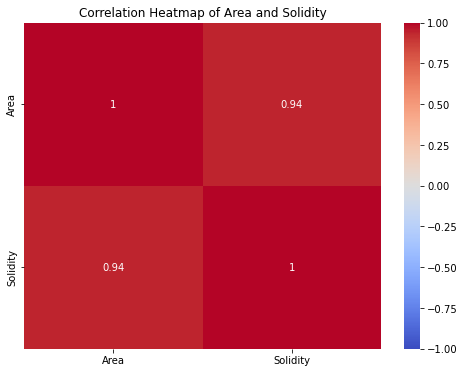

In [19]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Area', y='Solidity', hue='Label', data=df, palette='Set1')
plt.title('Scatter Plot of Area vs Solidity by Label')
plt.xlabel('Area')
plt.ylabel('Solidity')
plt.legend()
plt.show()

correlation_matrix = df[['Area', 'Solidity']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Area and Solidity')
plt.show()

# **Statistical Tests**

In [20]:
stat_area, p_area = stats.shapiro(df['Area'])
stat_solidity, p_solidity = stats.shapiro(df['Solidity'])

print(f"Shapiro-Wilk test for 'Area': Statistic = {stat_area}, p-value = {p_area}")
print(f"Shapiro-Wilk test for 'Solidity': Statistic = {stat_solidity}, p-value = {p_solidity}")

anova_area = stats.f_oneway(df[df['Label'] == 'Confidence']['Area'],
                            df[df['Label'] == 'Confusion']['Area'],
                            df[df['Label'] == 'Stress']['Area'],
                            df[df['Label'] == 'Not Relevant']['Area'])
print(f"ANOVA test for 'Area' by Label: {anova_area}")

anova_solidity = stats.f_oneway(df[df['Label'] == 'Confidence']['Solidity'],
                                df[df['Label'] == 'Confusion']['Solidity'],
                                df[df['Label'] == 'Stress']['Solidity'],
                                df[df['Label'] == 'Not Relevant']['Solidity'])
print(f"ANOVA test for 'Solidity' by Label: {anova_solidity}")

Shapiro-Wilk test for 'Area': Statistic = 0.6846106052398682, p-value = 0.0
Shapiro-Wilk test for 'Solidity': Statistic = 0.8456391096115112, p-value = 0.0
ANOVA test for 'Area' by Label: F_onewayResult(statistic=nan, pvalue=nan)
ANOVA test for 'Solidity' by Label: F_onewayResult(statistic=nan, pvalue=nan)


c:\Users\Laptop\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\Users\Laptop\anaconda3\lib\site-packages\scipy\stats\stats.py:3621: F_onewayBadInputSizesWarning: at least one input has length 0
  warnings.warn(F_onewayBadInputSizesWarning('at least one input '


# **Feature Scaling**

In [21]:
scaler = StandardScaler()
df[['Area', 'Solidity']] = scaler.fit_transform(df[['Area', 'Solidity']])

print(df.head())

            Filename      Area  Solidity       Label
0  circle100_104.png  1.594317  1.660911  Confidence
1  circle100_106.png  1.612043  1.609394  Confidence
2  circle100_109.png  1.591518  1.511297  Confidence
3  circle100_118.png  1.617641  1.474168  Confidence
4  circle100_125.png  1.670821  1.538347  Confidence


# **Class Imbalance**

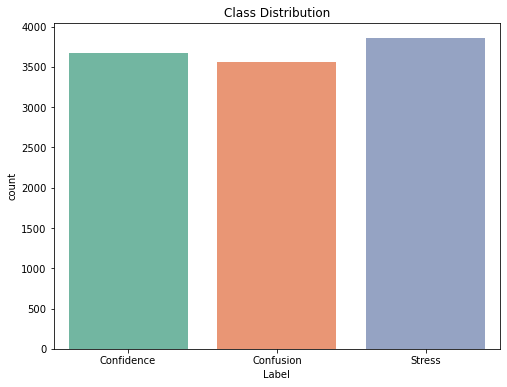

In [22]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Label', data=df, palette='Set2')
plt.title('Class Distribution')
plt.show()

# **Train Model and Evaluation**

Accuracy: 0.93
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.94       720
           1       0.94      0.84      0.89       723
           2       0.92      1.00      0.96       774

    accuracy                           0.93      2217
   macro avg       0.93      0.93      0.93      2217
weighted avg       0.93      0.93      0.93      2217



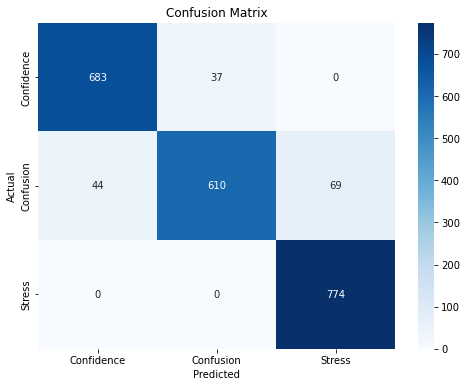

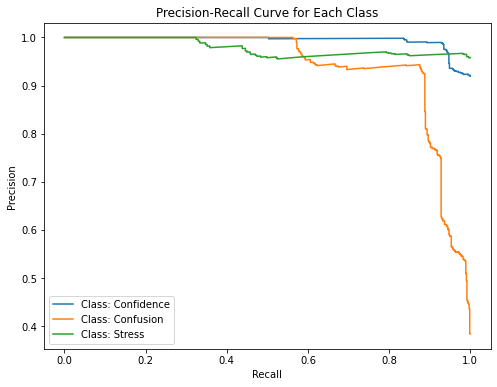

In [23]:
dataset_path = r'C:\Users\Laptop\extracted_bubbles\filled_circles'

X, y, filenames = load_and_preprocess_images(dataset_path)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(images, y_encoded, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000, multi_class='ovr', solver='lbfgs')
model.fit(X_train, y_train)

predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)

cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

y_proba = model.predict_proba(X_test)

plt.figure(figsize=(8, 6))
for i, label in enumerate(label_encoder.classes_):
    precision, recall, _ = precision_recall_curve(y_test == i, y_proba[:, i])
    plt.plot(recall, precision, label=f'Class: {label}')

plt.title('Precision-Recall Curve for Each Class')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# **Predicting Label for Images**

In [24]:
def result(test_path):

    # Preprocess the single image
    img, binary = preprocess_image(test_path)
    features = extract_features(binary)

    if not features:
        raise ValueError("No features found in the image.")

    # Assuming the first feature set is representative
    area, solidity = features[0]

    # Scale the features
    scaled_features = scaler.transform([[area, solidity]])

    # Predict the label
    predicted_label_encoded = model.predict(scaled_features)
    predicted_label = label_encoder.inverse_transform(predicted_label_encoded)

    print(f"Predicted label for the image '{test_path}': {predicted_label[0]}")
    
    plt.imshow(img, cmap='gray')  # Show the image
    plt.title(f"Predicted label: {predicted_label}")
    plt.axis('off')
    plt.show()

In [25]:
from Bubbles import extract_circles
from anotherBubbles import classify_circles

test_folder = r'C:\Users\Laptop\test'
output_circles_folder = rf'{test_folder}\Extracted_Circles_from_OMR'

print("Starting circle extraction...")
extract_circles(test_folder, output_circles_folder)

print("Starting circle classification...")
classify_circles(output_circles_folder)

filled = r"C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles"

Starting circle extraction...
1 C:\Users\Laptop\test\1.jpg
Saved circle 1 to C:\Users\Laptop\test\Extracted_Circles_from_OMR\circle2_1.png
Saved circle 2 to C:\Users\Laptop\test\Extracted_Circles_from_OMR\circle2_2.png
Saved circle 3 to C:\Users\Laptop\test\Extracted_Circles_from_OMR\circle2_3.png
Saved circle 4 to C:\Users\Laptop\test\Extracted_Circles_from_OMR\circle2_4.png
Saved circle 5 to C:\Users\Laptop\test\Extracted_Circles_from_OMR\circle2_5.png
Saved circle 6 to C:\Users\Laptop\test\Extracted_Circles_from_OMR\circle2_6.png
Saved circle 7 to C:\Users\Laptop\test\Extracted_Circles_from_OMR\circle2_7.png
Saved circle 8 to C:\Users\Laptop\test\Extracted_Circles_from_OMR\circle2_8.png
Saved circle 9 to C:\Users\Laptop\test\Extracted_Circles_from_OMR\circle2_9.png
Saved circle 10 to C:\Users\Laptop\test\Extracted_Circles_from_OMR\circle2_10.png
Saved circle 11 to C:\Users\Laptop\test\Extracted_Circles_from_OMR\circle2_11.png
Saved circle 12 to C:\Users\Laptop\test\Extracted_Circles

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle2_111.png': Confusion


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


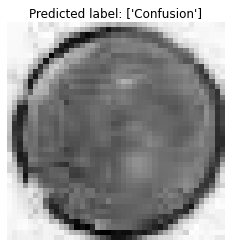

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle2_112.png': Confusion


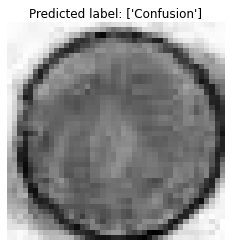

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle2_116.png': Confusion


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


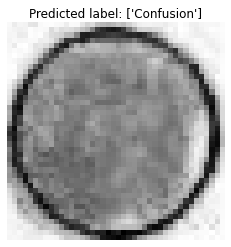

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle2_117.png': Confusion


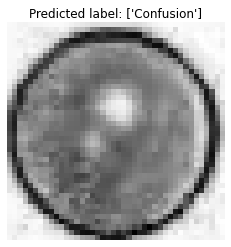

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle2_120.png': Confusion


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


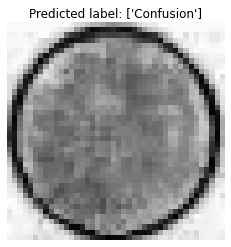

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle2_128.png': Confusion


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


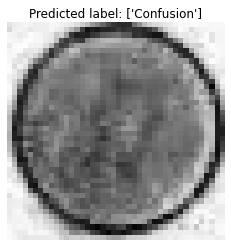

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle2_135.png': Confusion


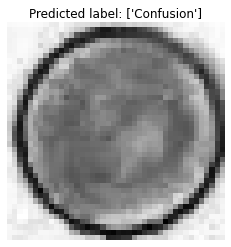

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle2_149.png': Stress


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


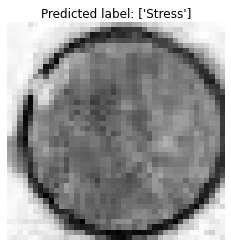

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle2_154.png': Confusion


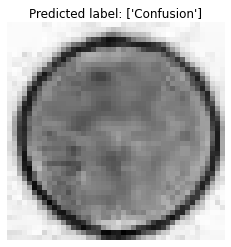

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle2_155.png': Stress


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


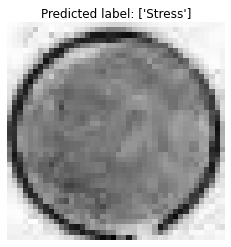

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle2_162.png': Stress


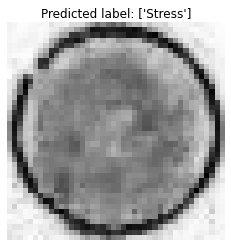

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle2_169.png': Stress


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


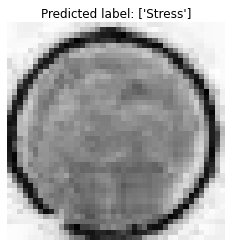

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle2_172.png': Confusion


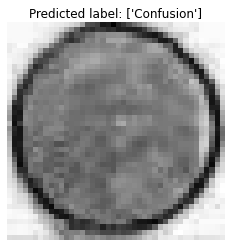

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle2_175.png': Confusion


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


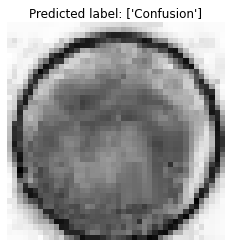

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle2_177.png': Confusion


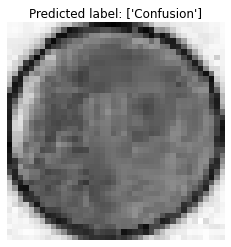

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle2_183.png': Confusion


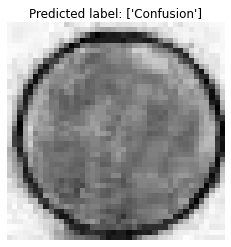

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle2_187.png': Stress


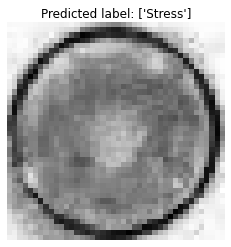

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle2_193.png': Confusion


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


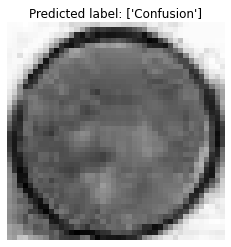

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle2_196.png': Confusion


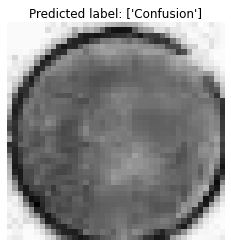

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle2_197.png': Confusion


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


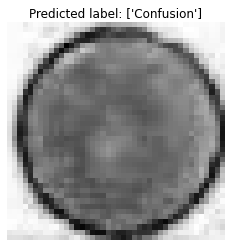

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle2_20.png': Confusion


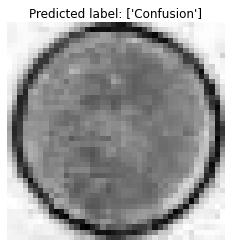

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle2_204.png': Stress


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


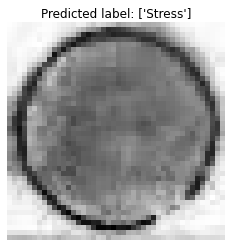

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle2_215.png': Confusion


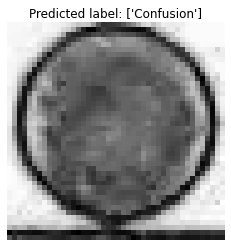

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle2_216.png': Stress


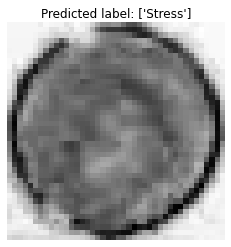

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle2_222.png': Stress


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


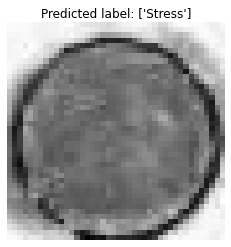

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle2_225.png': Stress


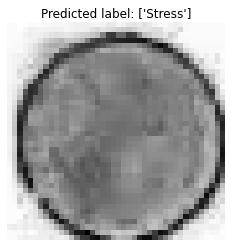

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle2_226.png': Confusion


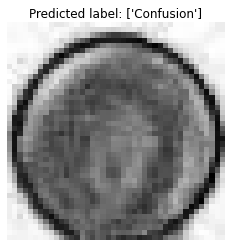

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle2_230.png': Stress


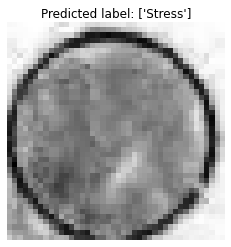

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle2_234.png': Stress


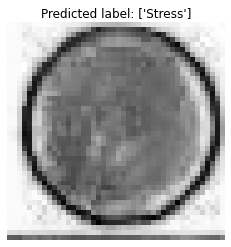

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle2_235.png': Stress


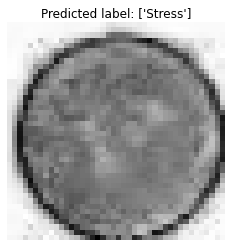

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle2_236.png': Confusion


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


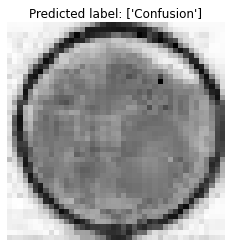

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle2_237.png': Confusion


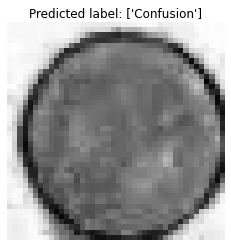

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle2_239.png': Stress


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


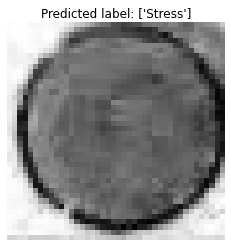

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle2_240.png': Confusion


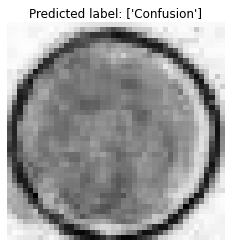

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle2_241.png': Stress


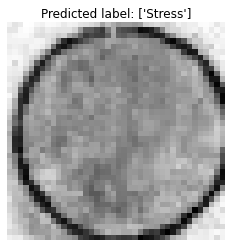

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle2_244.png': Confusion


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


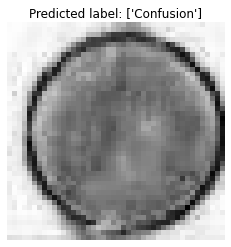

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle2_245.png': Confusion


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


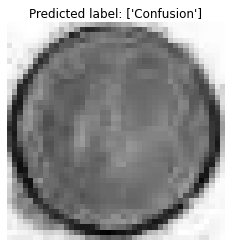

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle2_248.png': Stress


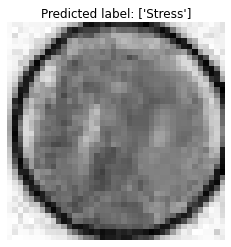

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle2_249.png': Stress


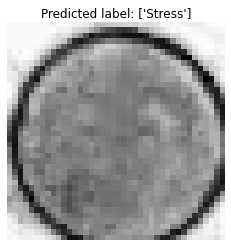

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle2_45.png': Stress


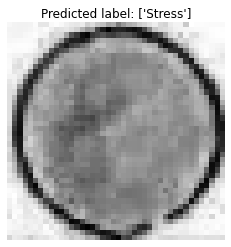

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle2_60.png': Confusion


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


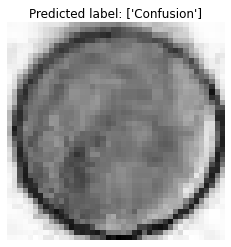

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle2_77.png': Stress


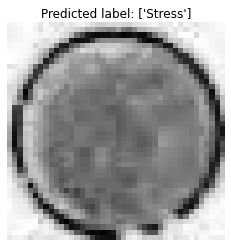

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle2_84.png': Confusion


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


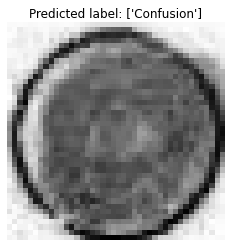

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle2_92.png': Stress


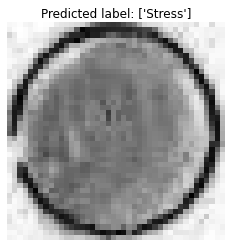

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle2_99.png': Confusion


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


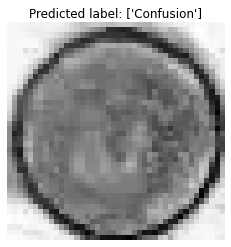

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle3_103.png': Confusion


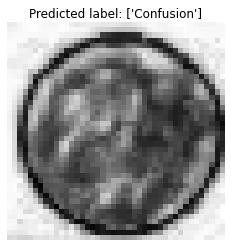

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle3_104.png': Confusion


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


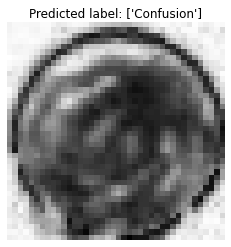

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle3_105.png': Stress


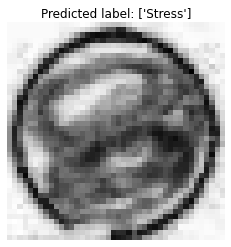

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle3_106.png': Confusion


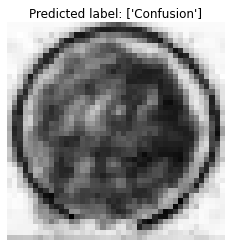

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle3_114.png': Confusion


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


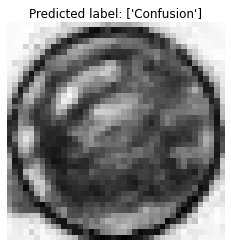

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle3_116.png': Stress


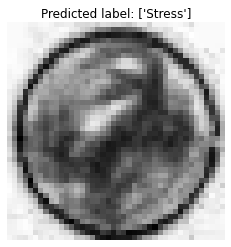

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle3_118.png': Stress


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


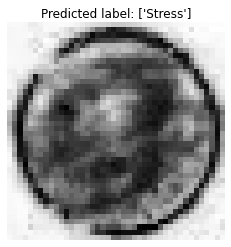

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle3_125.png': Confusion


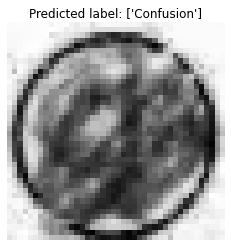

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle3_128.png': Confusion


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


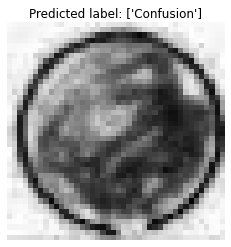

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle3_129.png': Stress


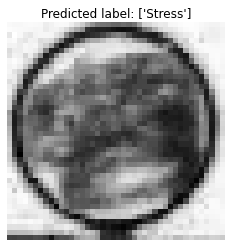

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle3_130.png': Confusion


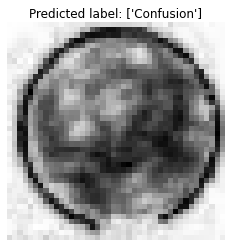

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle3_131.png': Stress


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


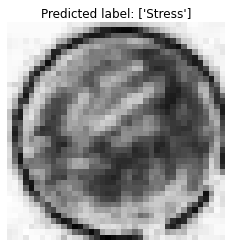

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle3_132.png': Stress


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


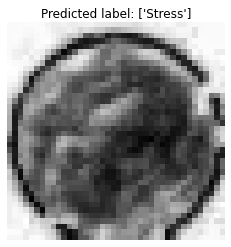

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle3_137.png': Confusion


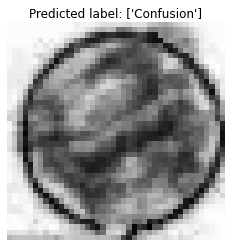

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle3_140.png': Confusion


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


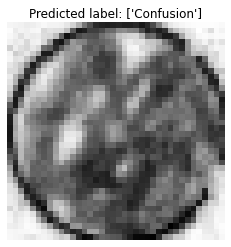

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle3_144.png': Confusion


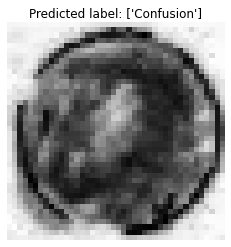

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle3_146.png': Stress


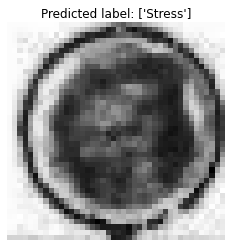

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle3_148.png': Confusion


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


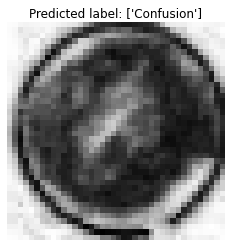

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle3_149.png': Stress


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


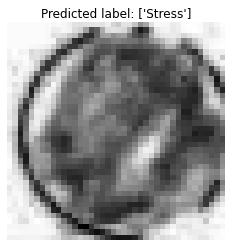

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle3_155.png': Confusion


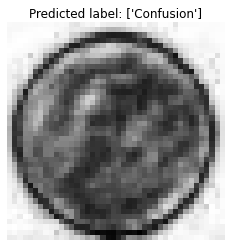

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle3_158.png': Confusion


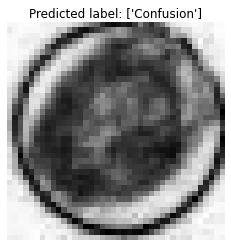

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle3_165.png': Confusion


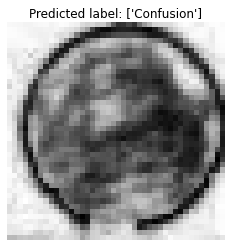

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle3_167.png': Confusion


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


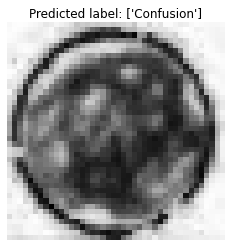

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle3_169.png': Confusion


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


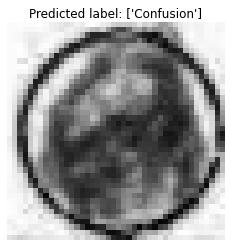

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle3_183.png': Stress


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


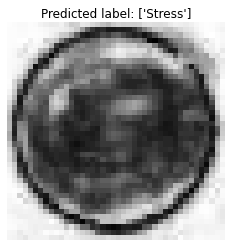

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle3_188.png': Confusion


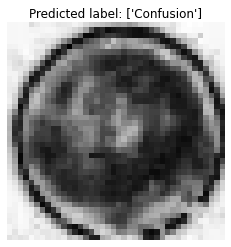

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle3_194.png': Confusion


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


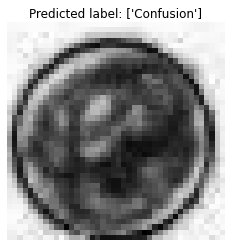

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle3_195.png': Stress


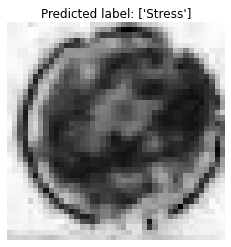

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle3_201.png': Confusion


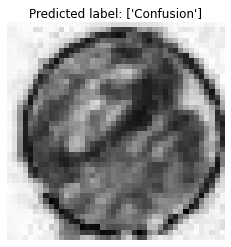

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle3_209.png': Stress


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


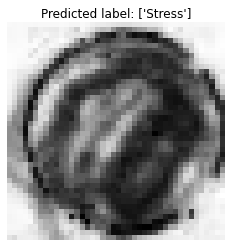

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle3_222.png': Stress


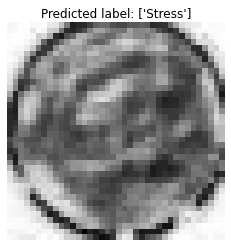

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle3_223.png': Stress


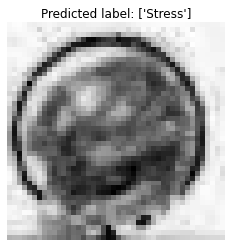

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle3_224.png': Stress


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


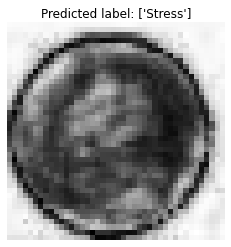

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle3_226.png': Confusion


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


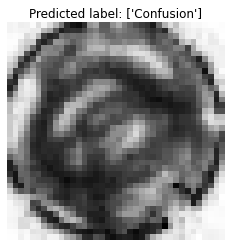

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle3_31.png': Confusion


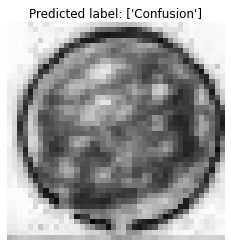

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle3_36.png': Confusion


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


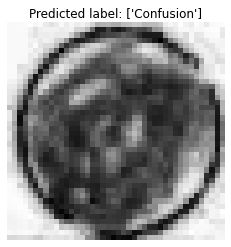

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle3_50.png': Stress


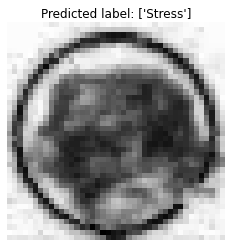

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle3_52.png': Stress


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


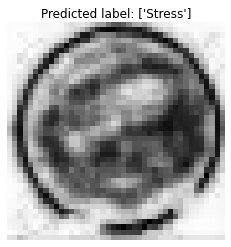

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle3_57.png': Confusion


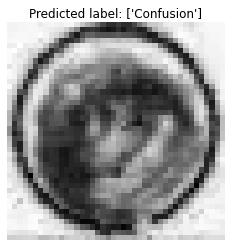

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle3_64.png': Confusion


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


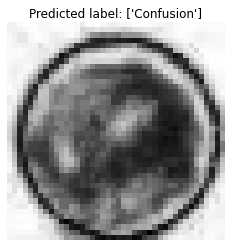

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle3_65.png': Confusion


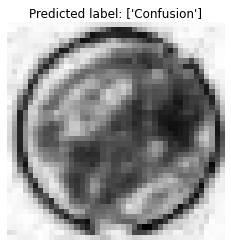

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle3_68.png': Stress


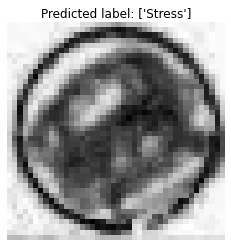

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle3_69.png': Stress


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


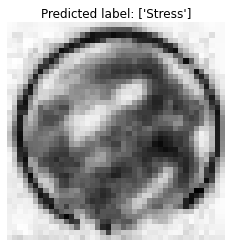

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle3_84.png': Confusion


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


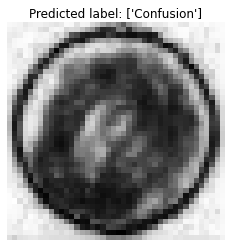

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle3_90.png': Confusion


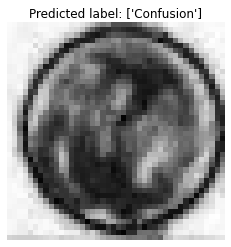

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle3_95.png': Stress


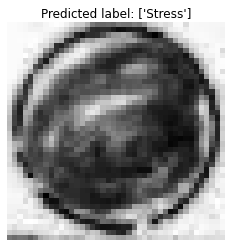

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle3_99.png': Confusion


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


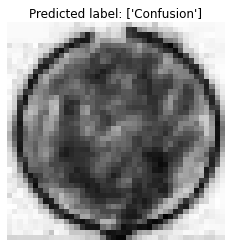

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle4_102.png': Confusion


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


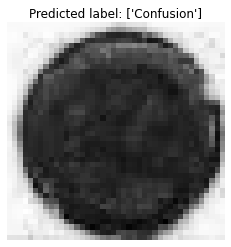

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle4_114.png': Confusion


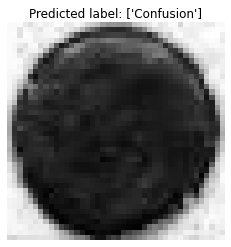

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle4_116.png': Confusion


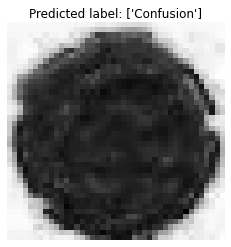

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle4_121.png': Confusion


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


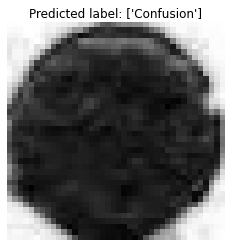

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle4_122.png': Confusion


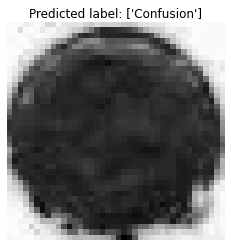

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle4_123.png': Confusion

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


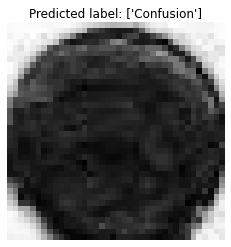

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle4_134.png': Confusion


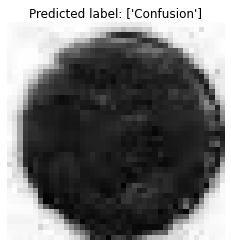

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle4_135.png': Confusion


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


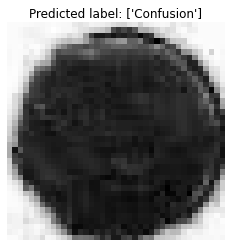

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle4_136.png': Confusion


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


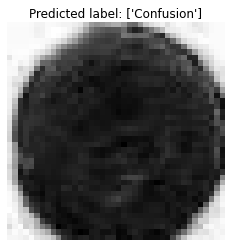

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle4_141.png': Confusion


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


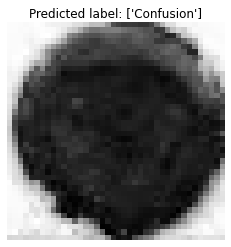

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle4_146.png': Confusion


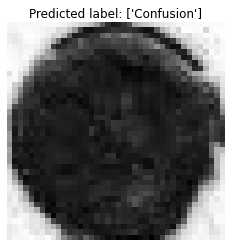

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle4_154.png': Confusion


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


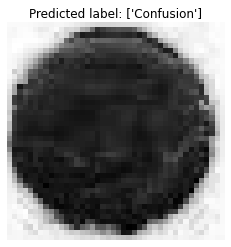

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle4_16.png': Confusion


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


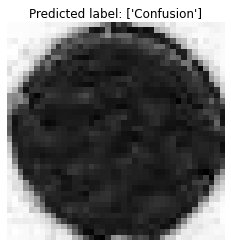

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle4_168.png': Confusion


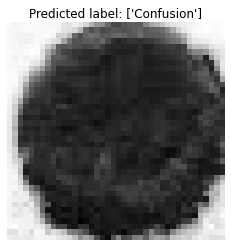

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle4_173.png': Confusion


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


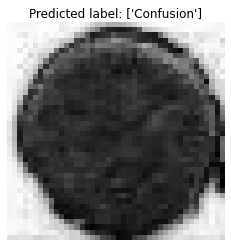

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle4_174.png': Confusion


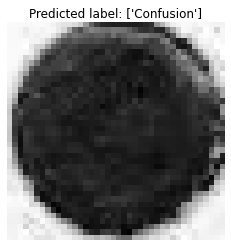

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle4_177.png': Confusion


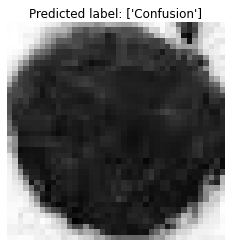

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle4_179.png': Stress


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


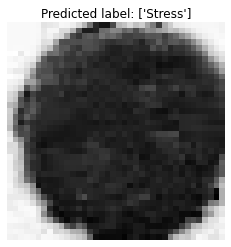

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle4_184.png': Confusion


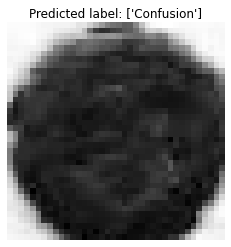

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle4_196.png': Confusion


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


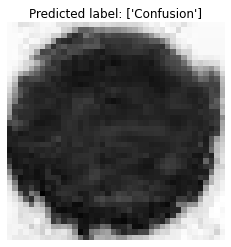

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle4_199.png': Confusion


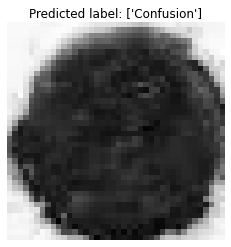

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle4_2.png': Confusion


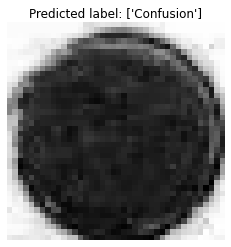

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle4_204.png': Confusion


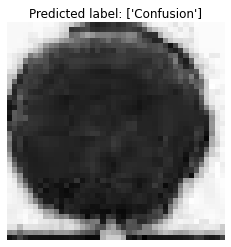

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle4_209.png': Confusion


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


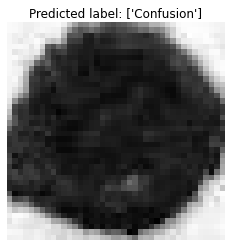

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle4_211.png': Confusion


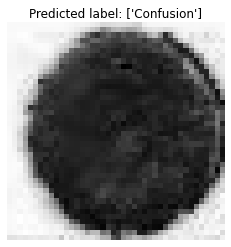

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle4_212.png': Confusion


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


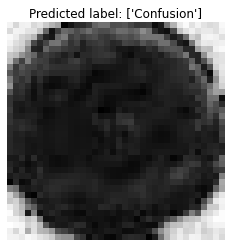

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle4_216.png': Confusion


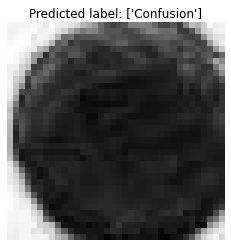

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle4_24.png': Confusion


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


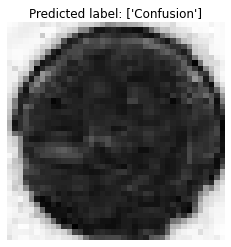

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle4_34.png': Confusion


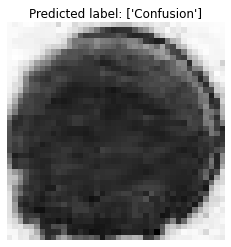

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle4_36.png': Confusion


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


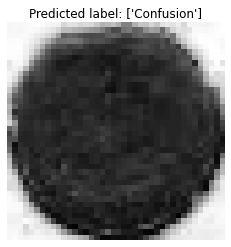

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle4_46.png': Confusion


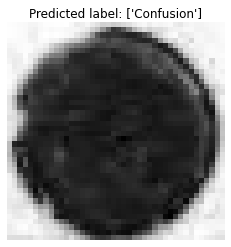

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle4_57.png': Confusion


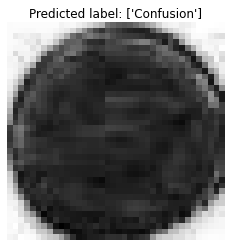

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle4_62.png': Confusion


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


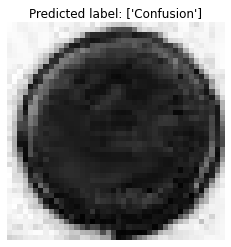

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle4_71.png': Confusion


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


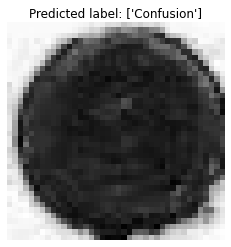

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle4_75.png': Confusion


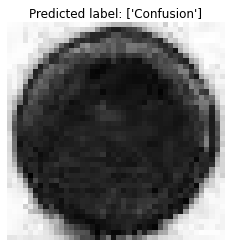

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle4_82.png': Confusion


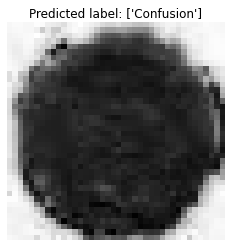

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle4_83.png': Confusion


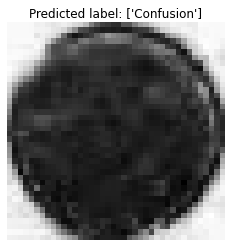

Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle4_84.png': Confusion


c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


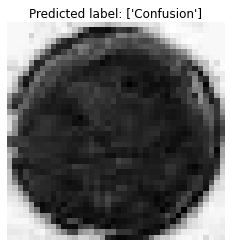

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle4_90.png': Confusion


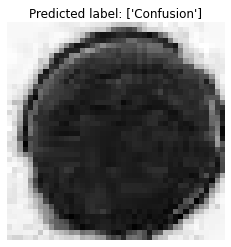

c:\Users\Laptop\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted label for the image 'C:\Users\Laptop\test\Extracted_Circles_from_OMR\filled_circles\circle4_92.png': Confusion


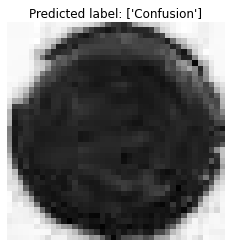

In [28]:
for each_circle in os.listdir(filled):
    result(os.path.join(filled, each_circle))
    # print(each_circle)